In [1]:
#installing libraries
!pip install tokenizers

In [2]:
#importing libraries
import os
import re
import pandas
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tokenizers import Tokenizer,models,pre_tokenizers,decoders,trainers,normalizers
from torch.utils.data import Dataset,DataLoader

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Data Preparation

# define a function to merge my txt files and clean them

def merge_and_clean(filepaths,output):
  bengali_pattern = re.compile(r"[^\u0980-\u09FF\u09E6-\u09EF\s.,!?;:()\"'—-]")
  with open(output,'w',encoding = 'utf-8') as output_file:
    for file in filepaths:
      with open(file,'r',encoding = 'utf-8') as inp_file:
        for line in inp_file:
          clean_line = bengali_pattern.sub("",line)
          clean_line = re.sub(r"\s+", " ", clean_line).strip()
          if clean_line:
            output_file.write(clean_line + "\n")

  return output

# define a function to add end_of_sentence

def add_eos(text):
  parts = re.split(r"([।!?])", text)
  final_sentences = []

  for i in range(0,len(parts)-1,2):
    sentence = parts[i].strip()
    ender = parts[i+1].strip()

    if sentence:
      final_sentences.append(sentence + ender+ '<eos>')

  return " ".join(final_sentences)

# function to read a text file
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read().replace('\n'," ")

    return text

# function to train our BPE tokenizer on our text data

def train_and_save_bpe_tokenizer(text,vocab_size,out_dir = '/content/bpe_tokenizer.json'):

    # separate sentences
    sentences = [s.strip() + "<eos>" for s in text.split("<eos>") if s.strip()]

    # Initialize tokenizer
    tokenizer = Tokenizer(models.BPE())
    tokenizer.normalizer = normalizers.NFKC()
    tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=True)


    #trainer
    trainer = trainers.BpeTrainer(
        vocab_size = vocab_size,
        special_tokens = ['<eos>']
    )

    #train
    tokenizer.train_from_iterator(sentences,trainer = trainer)

    # decoder
    tokenizer.decoder = decoders.ByteLevel()

    #save
    tokenizer.save(out_dir)
    print(f"tokenizer saved at {out_dir}")



    return sentences



In [ ]:
# filepaths = ['/content/drive/MyDrive/BanglaCompleteSentenceSeparation/azad_bhai.txt','/content/drive/MyDrive/BanglaCompleteSentenceSeparation/scraped_bengali_text.txt']
# output = '/content/merged.txt'
# merge_and_clean(filepaths,output)

'/content/merged.txt'

In [4]:
output = '/content/merged.txt'

In [5]:
text = read_text_file(output)
text

'ধর্মভিত্তিক রাজনৈতিক দল বিজেপি ভারতে একাদিক্রমে তিনবার ক্ষমতায় আসতে যাচ্ছে কিন্তু বাংলাদেশে কোনো ধর্মভিত্তিক দল এককভাবে ক্ষমতায় আসা দূরের কথা; সম্মিলিতভাবেও কুড়িটা আসন পায় না, আওয়ামি লিগ-বিএনপির সাথে লেজুড় হয়ে জোট বেঁধে অল্পকিছু আসন পায়, সাষ্টাঙ্গ আনুগত্যের পরিচয় দিয়ে কালেভদ্রে দু-একটা মন্ত্রিত্ব পায় কিন্তু কেন? বাংলাদেশে ধর্মানুভূতি যারপরনাই প্রখর হলেও জাতীয় নির্বাচনে ধর্মভিত্তিক রাজনৈতিক দলগুলোর এই বেহাল দশা কেন? এর উত্তর পাওয়া যাবে ভয়ের দেশে লয়ের দেশে বইয়ের একটি প্রবন্ধে প্রবন্ধটির লিংক কমেন্টে দেওয়া হলো স্বাধীন বাংলাদেশে অদ্যাবধি সাধারণ নির্বাচন অনুষ্ঠিত হয়েছে বারোবার প্রধান বিরোধীদল অংশগ্রহণ করেনি এর মধ্যে চারবার— চতুর্থ (১৯৮৮), ষষ্ঠ (১৯৯৬), দশম (২০১৪) আর দ্বাদশ (২০২৪) সাধারণ নির্বাচনে প্রধান বিরোধীদলবিহীন নির্বাচন এরশাদের আমলে দেখা গেছে একবার, খালেদা জিয়ার আমলে একবার, শেখ হাসিনার আমলে দুইবার প্রধান বিরোধীদলবিহীন নির্বাচন সংঘটনে বাংলাদেশে এই মুহূর্তে এককভাবে শীর্ষস্থান দখল করে আছেন শেখ হাসিনাই বিরোধীদলগুলো ১৯৮৮ সালের নির্বাচন বর্জন করেছিল এরশাদবিরোধী আন্দোলনের অংশ হিশেবে, আওয়ামি 

In [6]:
text_with_eos = add_eos(text)
text_with_eos

'ধর্মভিত্তিক রাজনৈতিক দল বিজেপি ভারতে একাদিক্রমে তিনবার ক্ষমতায় আসতে যাচ্ছে কিন্তু বাংলাদেশে কোনো ধর্মভিত্তিক দল এককভাবে ক্ষমতায় আসা দূরের কথা; সম্মিলিতভাবেও কুড়িটা আসন পায় না, আওয়ামি লিগ-বিএনপির সাথে লেজুড় হয়ে জোট বেঁধে অল্পকিছু আসন পায়, সাষ্টাঙ্গ আনুগত্যের পরিচয় দিয়ে কালেভদ্রে দু-একটা মন্ত্রিত্ব পায় কিন্তু কেন?<eos> বাংলাদেশে ধর্মানুভূতি যারপরনাই প্রখর হলেও জাতীয় নির্বাচনে ধর্মভিত্তিক রাজনৈতিক দলগুলোর এই বেহাল দশা কেন?<eos> এর উত্তর পাওয়া যাবে ভয়ের দেশে লয়ের দেশে বইয়ের একটি প্রবন্ধে প্রবন্ধটির লিংক কমেন্টে দেওয়া হলো স্বাধীন বাংলাদেশে অদ্যাবধি সাধারণ নির্বাচন অনুষ্ঠিত হয়েছে বারোবার প্রধান বিরোধীদল অংশগ্রহণ করেনি এর মধ্যে চারবার— চতুর্থ (১৯৮৮), ষষ্ঠ (১৯৯৬), দশম (২০১৪) আর দ্বাদশ (২০২৪) সাধারণ নির্বাচনে প্রধান বিরোধীদলবিহীন নির্বাচন এরশাদের আমলে দেখা গেছে একবার, খালেদা জিয়ার আমলে একবার, শেখ হাসিনার আমলে দুইবার প্রধান বিরোধীদলবিহীন নির্বাচন সংঘটনে বাংলাদেশে এই মুহূর্তে এককভাবে শীর্ষস্থান দখল করে আছেন শেখ হাসিনাই বিরোধীদলগুলো ১৯৮৮ সালের নির্বাচন বর্জন করেছিল এরশাদবিরোধী আন্দোলনের অংশ হিশেব

In [7]:
output_dir = "/content/bpe_tokenizer.json" # change this directory link
sentences= train_and_save_bpe_tokenizer(text_with_eos,10000,output_dir)

tokenizer saved at /content/bpe_tokenizer.json


In [ ]:
for s in sentences[:10]:
  print(s)

ধর্মভিত্তিক রাজনৈতিক দল বিজেপি ভারতে একাদিক্রমে তিনবার ক্ষমতায় আসতে যাচ্ছে কিন্তু বাংলাদেশে কোনো ধর্মভিত্তিক দল এককভাবে ক্ষমতায় আসা দূরের কথা; সম্মিলিতভাবেও কুড়িটা আসন পায় না, আওয়ামি লিগ-বিএনপির সাথে লেজুড় হয়ে জোট বেঁধে অল্পকিছু আসন পায়, সাষ্টাঙ্গ আনুগত্যের পরিচয় দিয়ে কালেভদ্রে দু-একটা মন্ত্রিত্ব পায় কিন্তু কেন?<eos>
বাংলাদেশে ধর্মানুভূতি যারপরনাই প্রখর হলেও জাতীয় নির্বাচনে ধর্মভিত্তিক রাজনৈতিক দলগুলোর এই বেহাল দশা কেন?<eos>
এর উত্তর পাওয়া যাবে ভয়ের দেশে লয়ের দেশে বইয়ের একটি প্রবন্ধে প্রবন্ধটির লিংক কমেন্টে দেওয়া হলো স্বাধীন বাংলাদেশে অদ্যাবধি সাধারণ নির্বাচন অনুষ্ঠিত হয়েছে বারোবার প্রধান বিরোধীদল অংশগ্রহণ করেনি এর মধ্যে চারবার— চতুর্থ (১৯৮৮), ষষ্ঠ (১৯৯৬), দশম (২০১৪) আর দ্বাদশ (২০২৪) সাধারণ নির্বাচনে প্রধান বিরোধীদলবিহীন নির্বাচন এরশাদের আমলে দেখা গেছে একবার, খালেদা জিয়ার আমলে একবার, শেখ হাসিনার আমলে দুইবার প্রধান বিরোধীদলবিহীন নির্বাচন সংঘটনে বাংলাদেশে এই মুহূর্তে এককভাবে শীর্ষস্থান দখল করে আছেন শেখ হাসিনাই বিরোধীদলগুলো ১৯৮৮ সালের নির্বাচন বর্জন করেছিল এরশাদবিরোধী আন্দোলনের অংশ হিশেবে

In [8]:
bpe_tokenizer = Tokenizer.from_file('/content/bpe_tokenizer.json') # replace the file path with output_dir
vocab = bpe_tokenizer.get_vocab()

print(f"Vocabulary size: {len(vocab)}")
print(f"Vocabulary sample: {list(vocab.items())[:10]}")

Vocabulary size: 5515
Vocabulary sample: [('Ġà¦ħà¦¤à¦¨', 2488), ('à¦·à¦¡', 3089), ('à¦¸à¦¦à¦¦', 2399), ('à¦¡à¦ıà¦®', 2719), ('à¦¬à¦¨à¦¤', 3773), ('Ġà¦¸à¦ļà¦ķ', 3450), ('à¦ķà¦ªà¦°', 1987), ('à¦ĸà¦ªà¦¤', 1576), ('à¦Ĺà¦ķà¦°', 3086), ('à¦¨à¦¸à¦Ń', 5223)]


In [9]:
# 3️⃣ Encode some text
text = "বাংলা ভাষা খুব সুন্দর।<eos>"
encoding = bpe_tokenizer.encode(text)
print("Token IDs:", encoding.ids)
print("Tokens:", encoding.tokens)

# 4️⃣ Decode back to text
decoded_text = bpe_tokenizer.decode(encoding.ids)
print("Decoded text:", decoded_text)

Token IDs: [92, 174, 86, 77, 134, 77, 115, 77, 145, 90, 88, 93, 90, 82, 81, 380, 40, 21, 20, 0]
Tokens: ['Ġà¦¬', 'à¦¾à¦Ĥ', 'à¦²', 'à¦¾', 'Ġà¦Ń', 'à¦¾', 'à¦·', 'à¦¾', 'Ġà¦ĸ', 'à§ģ', 'à¦¬', 'Ġà¦¸', 'à§ģ', 'à¦¨', 'à§į', 'à¦¦à¦°', 'à', '¥', '¤', '<eos>']
Decoded text:  বাংলা ভাষা খুব সুন্দর।


In [10]:
#creating a dataset for my text.

class ShamDataset(Dataset):
  def __init__(self,text,tokenizer,max_len,stride):
    #defining input and targert
    self.input_ids = []
    self.target_ids = []

    #tokenize the text
    print(f"len of text is {len(text)}")
    tokens = tokenizer.encode(text).ids
    print(f"len of tokens is {len(tokens)}")
    print(f"max len is {max_len}")



    for i in range(0,len(tokens) - max_len,stride):
      inp_chunk = tokens[i:i+max_len]
      target_chunk = tokens[i+1:i+1+max_len]
      if len(inp_chunk) == max_len and len(target_chunk) == max_len:
        self.input_ids.append(torch.tensor(inp_chunk))
        self.target_ids.append(torch.tensor(target_chunk))


  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, index):
    return self.input_ids[index], self.target_ids[index]



def create_dataloader(text,tokenizer,max_len,stride,batch_size,shuflle = True, drop_last= True, worker = 0):

  dataset = ShamDataset(text,tokenizer,max_len,stride)
  dataloader = DataLoader(dataset,batch_size = batch_size,shuffle = shuflle,drop_last = drop_last,num_workers = worker)

  return dataloader




In [11]:
train_text = text_with_eos[:int(0.9*len(text_with_eos))]   # first 90%
val_text   = text_with_eos[int(0.9*len(text_with_eos)):]   # last 10%
val_text


'াদের নতুন ভাষায় নতুন কবিতা লেখার অনুপ্রেরণা যুগিয়েছেন তিনি আজ কবিদের কবি এক নতুন বোধের শিহরণ ও আলোড়ন দেখি তাঁর অনেক কবিতায় কবিতার এমন এক গল্পের ভেতরে আমাদের নিয়ে যান তিনি যে আমরা সেই গল্পের মুখোমুখি দাঁড়িয়ে প্রচ-ভাবে অসহায় বোধ করি মনে পড়ে কবে এক রাত্রির স্বপ্নের ভিতরে শুনেছি একটি কুষ্ঠকলঙ্কিত নারী কেমন আশ্চর্য গান গায়; বোবা কালা পাগল মিনসে এক অপরূপ বেহালা বাজায়; গানের ঝংকারে যেন সে এক একান্ত শ্যাম দেবদারু গাছে রাত্রির বর্ণের মতো কালো-কালো শিকারী বেড়াল প্রেম নিবেদন করে আলোর রঙের মতো অগণন পাখিদের কাছে; (এই সব দিনরাত্রি : বেলা অবেলা কালবেলা) এই কতিায় ফ্রয়েডীয় অবদমনের (জবঢ়ৎবংংরড়হ) ইঙ্গিত রয়েছে এছাড়া এই কবিতার ভাষিক আয়োজন এমনই সব চিত্রকল্পের কাছাকাছি নিয়ে যায় আমাদের যে আমরা শুধু ভেবে যেতে পারি এই কবির সৃষ্টি কৌশলের অভিনবত্ব ও সংগ্রাম ভাবনার নতুন দিগন্তের খোঁজে তাঁর মন ও হৃদয় যেন সারাক্ষণ এক অবিচল নৈঃশব্দ্যের মধ্যে ডুবে থেকেছে নতুন দিনের কবিতার জন্যে, কবিতার নতুন পথ তৈরির অদম্য আশায় তার কবিতায় আছে বেদনার উন্মেষ অথবা উন্মেষের বেদনা যা তার ব্যক্তিমানসের এক নিষ্ঠুর অমোঘ বাস্তবতা এই বাস্তবতা থ

In [12]:
stride = 5
batch = 10
val_batch = 4
max_len = 256
train_dataloader = create_dataloader(train_text,bpe_tokenizer,max_len,stride,batch)
val_dataloader = create_dataloader(val_text,bpe_tokenizer,max_len,stride,val_batch,shuflle= False)
d_iter = iter(train_dataloader)
first_batch = next(d_iter)
print(first_batch)
print(f"train dataset size {len(train_dataloader)}")
print(f"val dataset size {len(val_dataloader)}")

len of text is 1609677
len of tokens is 1128747
max len is 256
len of text is 178853
len of tokens is 126618
max len is 256
[tensor([[ 80, 119,  77,  ..., 111, 113,  77],
        [ 83, 120, 538,  ..., 169,  90,  91],
        [ 77, 107,  81,  ...,  83, 105,  89],
        ...,
        [ 81, 101,  78,  ...,  78, 171, 113],
        [115,  81, 100,  ...,  83, 105, 108],
        [ 97, 113,  78,  ...,  78, 101,  80]]), tensor([[119,  77, 251,  ..., 113,  77,  84],
        [120, 538,  81,  ...,  90,  91,  78],
        [107,  81,  84,  ..., 105,  89,  78],
        ...,
        [101,  78, 159,  ..., 171, 113,  78],
        [ 81, 100,  80,  ..., 105, 108,  80],
        [113,  78, 873,  ..., 101,  80, 112]])]
train dataset size 22569
val dataset size 6318


In [13]:
# classes for multi head attention,transformer block and model
#multi head attention

class MultiheadAttention(nn.Module):
  def __init__(self,d_in,d_out,num_heads,context_length,dropout,bias_qkv = False):
    super().__init__()
    self.d_out = d_out
    self.heads = num_heads
    self.head_dim = d_out// num_heads


    self.q = nn.Linear(d_in,d_out,bias = bias_qkv)
    self.k = nn.Linear(d_in,d_out,bias = bias_qkv)
    self.v = nn.Linear(d_in,d_out,bias = bias_qkv)
    self.out_proj = nn.Linear(d_out,d_out)

    self.dropout = nn.Dropout(dropout)
    self.register_buffer("mask",torch.triu(torch.ones(context_length,context_length),diagonal=1))

  def forward(self,x):
    b,inp_seq,d_in = x.shape
    q = self.q(x)
    k = self.k(x)
    v = self.v(x)

    #reshaping the vectors
    q = q.view(b,inp_seq,self.heads,self.head_dim)
    k = k.view(b,inp_seq,self.heads,self.head_dim)
    v = v.view(b,inp_seq,self.heads,self.head_dim)
    q = q.transpose(1,2)
    k = k.transpose(1,2)
    v = v.transpose(1,2)

    atten_score = torch.matmul(q,k.transpose(2,3))
    atten_score.masked_fill_(self.mask.bool()[:inp_seq,:inp_seq],-torch.inf)

    attn_weight = torch.softmax((atten_score / k.shape[-1]**0.5),dim=-1)
    attn_weight = self.dropout(attn_weight)
    cnt_x = torch.matmul(attn_weight,v)
    cnt_x = cnt_x.transpose(1,2)
    #print(f"context  is {cnt_x}")
    cnt_x = cnt_x.contiguous().view(b,inp_seq,self.d_out)
    #print(f"context  is {cnt_x}")
    cnt_x = self.out_proj(cnt_x)

    return cnt_x

# Normalization class
class LayerNorm(nn.Module):
  def __init__(self,embed_dim):
    super().__init__()
    self.eps = 1e-6
    self.scale = nn.Parameter(torch.ones(embed_dim))
    self.shift = nn.Parameter(torch.zeros(embed_dim))

  def forward(self,x):
    mean = x.mean(dim=-1,keepdim = True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    norm_x = (x-mean)/torch.sqrt(var+self.eps)
    return self.scale * norm_x + self.shift

class RMSNorm(nn.Module):
    def __init__(self, embed_dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(embed_dim))  # only scale, no shift

    def forward(self, x):
        # Compute RMS over last dimension
        rms = torch.sqrt(x.pow(2).mean(dim=-1, keepdim=True) + self.eps)
        norm_x = x / rms
        return self.scale * norm_x


class SwiGLU(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.w1 = nn.Linear(dim, hidden_dim)
        self.w2 = nn.Linear(dim, hidden_dim)
        self.w3 = nn.Linear(hidden_dim, dim)

    def forward(self, x):
        return self.w3(self.w1(x) * F.silu(self.w2(x)))




In [14]:
# We will use Decoupled Rotarary Positional encoding and also use compress kv vector to save memeroy and fast inference

#Decoupled Rotarty Positinal encoding

# Function to make rotation of a 2d vector
def rotate_half(x):
  x1,x2 = x.chunk(2,dim=-1) # chunking a 2d vector with 2*2 matrix
  return torch.cat([-x2,x1],dim = -1) # minus sign ensure the rotation

# Another function to apply rotarary
def apply_rotary(x,cos,sin):
  # x is the input embedding (shape [batch, seq_len, hidden_dim]).cos and sin are precomputed rotation matrices (broadcastable tensors)
  # that have shape [batch, seq_len, rot_dim].cos.shape[-1] = rot_dim (the number of dimensions we apply RoPE to).
  #x_rot,x_pass = x.split(cos.shape[-1],dim = 1)
  x_rot = x[..., :cos.shape[-1]]   # first rope_dim dimensions
  x_pass = x[..., cos.shape[-1]:]

  # x_rot * cos will give (x1​,x2​)⋅cosθ=(x1​cosθ,x2​cosθ)
  # rotate_half(x_rot) * sin will give (−x2​,x1​)⋅sinθ=(−x2​sinθ,x1​sinθ)
  # by adding them we will get (x1​cosθ−x2​sinθ,x2​cosθ+x1​sinθ)

  x_rot = x_rot * cos + rotate_half(x_rot)*sin

  return torch.cat([x_rot,x_pass],dim = -1)
# DeRoPE class
class DeRoPE(nn.Module):
    def __init__(self, rope_dim, scale=40):
        super().__init__()
        assert rope_dim % 2 == 0, "rope_dim must be even for rotate_half()"
        self.rope_dim = rope_dim
        self.scale = scale

    def forward(self, x, seq_len=None, start_pos=0):
        """
        x: [B, L, H, D_r+]  (rotate first rope_dim)
        start_pos: absolute position offset for KV caching
        """
        if seq_len is None:
            seq_len = x.shape[1]

        device   = x.device
        half_dim = self.rope_dim // 2

        # angular frequencies
        inv_freq = 1.0 / (10000 ** (torch.arange(0, half_dim, device=device).float() / half_dim))
        t        = (torch.arange(seq_len, device=device).float() + start_pos) / self.scale  # add offset
        angles   = torch.einsum("l,d->ld", t, inv_freq)
        angles   = torch.cat([angles, angles], dim=-1)

        cos = angles.cos().unsqueeze(0).unsqueeze(2)  # [1, L, 1, rope_dim]
        sin = angles.sin().unsqueeze(0).unsqueeze(2)

        x_rot  = x[..., :self.rope_dim]
        x_pass = x[..., self.rope_dim:]
        x_rot = x_rot * cos + rotate_half(x_rot) * sin

        return torch.cat([x_rot, x_pass], dim=-1)




# Mulithead latent attention
class MultiHeadLatentAttention(nn.Module):
    def __init__(self, d_in, d_out, num_heads, rope_dim, compressed_dim, dropout, bias_qkv=False):
        super().__init__()
        assert rope_dim % 2 == 0, "rope_dim must be even"
        self.d_out     = d_out
        self.rope_dim  = rope_dim
        self.num_heads = num_heads
        self.head_dim  = d_out // num_heads
        self.split_dim = self.head_dim - self.rope_dim

        # KV compression
        self.W_dkv = nn.Linear(d_out, compressed_dim, bias=bias_qkv)
        self.W_dq  = nn.Linear(d_out, compressed_dim, bias=bias_qkv)

        # Expansion
        self.W_uk = nn.Linear(compressed_dim, num_heads * self.split_dim, bias=bias_qkv)
        self.W_uv = nn.Linear(compressed_dim, num_heads * self.head_dim,  bias=bias_qkv)
        self.W_uq = nn.Linear(compressed_dim, num_heads * self.split_dim, bias=bias_qkv)
        self.W_qr = nn.Linear(compressed_dim, num_heads * self.rope_dim,  bias=bias_qkv)
        self.W_kr = nn.Linear(compressed_dim, num_heads * self.rope_dim,  bias=bias_qkv)

        # RoPE
        self.rope   = DeRoPE(rope_dim)
        self.output = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, past_kv=None, use_causal_mask=True, seq_start=0):
        B, L, _ = x.shape

        # --- compress -> expand ---
        c_kv   = self.W_dkv(x)
        k_base = self.W_uk(c_kv).view(B, L, self.num_heads, self.split_dim)
        k_r    = self.W_kr(c_kv).view(B, L, self.num_heads, self.rope_dim)
        v      = self.W_uv(c_kv).view(B, L, self.num_heads, self.head_dim)

        c_q    = self.W_dq(x)
        q_base = self.W_uq(c_q).view(B, L, self.num_heads, self.split_dim)
        q_r    = self.W_qr(c_q).view(B, L, self.num_heads, self.rope_dim)

        # --- apply RoPE with absolute start position ---
        q = torch.cat([q_base, q_r], dim=-1)
        k = torch.cat([k_base, k_r], dim=-1)
        q = self.rope(q, seq_len=L, start_pos=seq_start)
        k = self.rope(k, seq_len=L, start_pos=seq_start)

        # --- KV cache concat ---
        if past_kv is not None:
            k_past, v_past = past_kv
            k = torch.cat([k_past, k], dim=1)
            v = torch.cat([v_past, v], dim=1)

        # --- attention ---
        scores = torch.einsum("bqhd,bkhd->bhqk", q, k) / math.sqrt(self.head_dim)
        if use_causal_mask:
            Lq, Lk = q.shape[1], k.shape[1]
            offset = Lk - Lq
            causal = torch.triu(torch.ones(Lq, Lk, device=x.device, dtype=torch.bool), diagonal=1+offset)
            scores = scores.masked_fill(causal[None, None, :, :], float("-inf"))

        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        cnt_x = torch.einsum("bhqk,bkhd->bqhd", attn, v).contiguous().view(B, -1, self.d_out)
        cnt_x = self.output(cnt_x)

        new_cache = (k, v)
        return cnt_x, new_cache
















In [15]:
# MoE Layer

# Expert (like your FFN but smaller)
class Expert(nn.Module):
    def __init__(self, emb_dim, hidden_dim):
        super().__init__()
        self.ffn = nn.Sequential(
            nn.Linear(emb_dim, hidden_dim),
            SwiGLU(hidden_dim,hidden_dim),
            nn.Linear(hidden_dim, emb_dim)
        )

    def forward(self, x):
        return self.ffn(x)


# Mixture of Experts
class MoE(nn.Module):
    def __init__(self, emb_dim, num_experts=4, hidden_dim=None, k=1):
        super().__init__()
        self.num_experts = num_experts
        self.k = k
        hidden_dim = hidden_dim or 4 * emb_dim

        # Create experts
        self.experts = nn.ModuleList([Expert(emb_dim, hidden_dim) for _ in range(num_experts)])

        # Gating network
        self.gate = nn.Linear(emb_dim, num_experts)

    def forward(self, x):
        # x: [batch, seq, emb]
        batch_size, seq_len, emb_dim = x.shape

        # Gating scores
        gate_scores = F.softmax(self.gate(x), dim=-1)   # [batch, seq, num_experts]

        # Select top-k experts
        topk_scores, topk_idx = torch.topk(gate_scores, self.k, dim=-1)  # both [batch, seq, k]

        # Normalize top-k scores
        topk_scores = topk_scores / topk_scores.sum(dim=-1, keepdim=True)

        # Compute expert outputs
        output = torch.zeros_like(x)

        for i in range(self.k):
            expert_idx = topk_idx[..., i]   # [batch, seq]
            expert_score = topk_scores[..., i].unsqueeze(-1)  # [batch, seq, 1]

            for e in range(self.num_experts):
                mask = (expert_idx == e).float().unsqueeze(-1)  # [batch, seq, 1]
                if mask.sum() == 0:
                    continue
                expert_out = self.experts[e](x)  # [batch, seq, emb]
                output += expert_out * expert_score * mask

        return output


# Replace your FeedForward with MoE
class FeedForwardMoE(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.moe = MoE(cfg['emb_dim'], num_experts=4, hidden_dim=4*cfg['emb_dim'], k=1)

    def forward(self, x):
        return self.moe(x)


In [ ]:
# Transformer block

class TransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.mhattention = MultiheadAttention(
        d_in = cfg['emb_dim'],
        d_out = cfg['emb_dim'],
        num_heads = cfg['num_heads'],
        context_length = cfg['context_length'],
        dropout = cfg['dropout'],
        bias_qkv = cfg['bias_qkv']
    )
    self.ln1 = LayerNorm(cfg['emb_dim'])
    self.ff = FeedForwardMoE(cfg)
    self.ln2 = LayerNorm(cfg['emb_dim'])
    self.dropout = nn.Dropout(cfg['dropout'])
    self.rmsnorm1 = RMSNorm(cfg['emb_dim'])
    self.rmsnorm2 = RMSNorm(cfg['emb_dim'])

  def forward(self,x):
    shortcut = x
    x = self.ln1(x)
    x = self.mhattention(x)
    x = self.rmsnorm1(x)
    x = self.dropout(x)
    x = shortcut + x  #adding residual connection

    shortcut = x
    x = self.ln2(x)
    x = self.ff(x)
    x = self.rmsnorm2(x)
    x = self.dropout(x)
    x = shortcut + x  #adding residual connection
    return x



In [16]:
# Transformer block with Multi head latent attention

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.mhattention = MultiHeadLatentAttention(
            d_in=cfg['emb_dim'],
            d_out=cfg['emb_dim'],
            num_heads=cfg['num_heads'],
            rope_dim=cfg['rope_dim'],
            compressed_dim=cfg['compressed_dim'],
            dropout=cfg['dropout'],
            bias_qkv=cfg['bias_qkv']
        )
        self.ln1 = LayerNorm(cfg['emb_dim'])
        self.ff = FeedForwardMoE(cfg)
        self.ln2 = LayerNorm(cfg['emb_dim'])
        self.dropout = nn.Dropout(cfg['dropout'])
        self.rmsnorm1 = RMSNorm(cfg['emb_dim'])
        self.rmsnorm2 = RMSNorm(cfg['emb_dim'])

    def forward(self, x, past_kv=None,seq_start=0):
        # Attention block
        shortcut = x
        x = self.ln1(x)
        x, updated_kv = self.mhattention(x, past_kv=past_kv,seq_start=seq_start)
        x = self.rmsnorm1(x)
        x = self.dropout(x)
        x = shortcut + x  # residual

        # Feed-forward block
        shortcut = x
        x = self.ln2(x)
        x = self.ff(x)
        x = self.rmsnorm2(x)
        x = self.dropout(x)
        x = shortcut + x  # residual

        return x, updated_kv




In [ ]:
#Gpt2 like architecure

class ShomsherGPT(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg['vocab_size'],cfg['emb_dim'])
    self.pos_emb = nn.Embedding(cfg['context_length'],cfg['emb_dim'])
    self.drop_emb = nn.Dropout(cfg['dropout'])
    self.t_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg['num_layers'])])
    self.final_ln = LayerNorm(cfg['emb_dim'])
    self.lm_head = nn.Linear(cfg['emb_dim'],cfg['vocab_size'])

  def forward(self,x):
    batch,seq_len = x.shape
    tok_emb = self.tok_emb(x)
    pos_emb = self.pos_emb(torch.arange(seq_len,device = x.device))
    x = tok_emb + pos_emb
    x = self.drop_emb(x)
    x = self.t_blocks(x)
    x = self.final_ln(x)
    logits = self.lm_head(x)
    return logits

In [17]:
# Hybrid Architecture
class ShomsherLLM(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['dropout'])

        # Can't use Sequential, because we need per-layer past_kv
        self.t_blocks = nn.ModuleList([TransformerBlock(cfg) for _ in range(cfg['num_layers'])])

        self.final_ln = LayerNorm(cfg['emb_dim'])
        self.lm_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'])

    def forward(self, x, return_cache=False, past_kv=None,seq_start=0):
        batch, seq_len = x.shape

        # Token embeddings only (RoPE handles positions)
        x = self.tok_emb(x)
        x = self.drop_emb(x)

        new_caches = []
        for i, block in enumerate(self.t_blocks):
            layer_past = past_kv[i] if past_kv is not None else None
            x, layer_cache = block(x, past_kv=layer_past,seq_start=seq_start)
            if return_cache:
                new_caches.append(layer_cache)

        x = self.final_ln(x)
        logits = self.lm_head(x)

        if return_cache:
            return logits, new_caches
        else:
            return logits


In [18]:
CONFIG = {
"vocab_size": 5515,
"context_length": 256,
"emb_dim": 200,
"num_heads": 8,
"num_layers": 6,
"dropout": 0.1,
"rope_dim":24,
"compressed_dim": 50,
"bias_qkv": False
}
torch.manual_seed(123)
model = ShomsherLLM(CONFIG)
#print(model)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

56606739


In [19]:
#validation loop

def evaluate_model(model, train_loader, val_loader, criterion, device, eval_iter=50):
    """Evaluate model on train & val sets (few batches for speed)."""
    model.eval()
    losses = {"train": [], "val": []}

    # Evaluation without gradients
    with torch.no_grad():
        # Training set loss (few batches only)
        for i, (input_batch, target_batch) in enumerate(train_loader):
            if i >= eval_iter: break
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            logits = model(input_batch)
            loss = criterion(logits.view(-1, logits.size(-1)), target_batch.view(-1))
            losses["train"].append(loss.item())

        # Validation set loss
        for i, (input_batch, target_batch) in enumerate(val_loader):
            if i >= eval_iter: break
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            logits = model(input_batch)
            loss = criterion(logits.view(-1, logits.size(-1)), target_batch.view(-1))
            losses["val"].append(loss.item())

    # Return average
    return sum(losses["train"]) / len(losses["train"]), sum(losses["val"]) / len(losses["val"])


In [ ]:
#trianing loop

def train_model(model,train_dataloader,val_dataloader,optimizer,num_epochs,eval_freq,device):
  loss_function = nn.CrossEntropyLoss()
  train_loss,val_loss = [],[]
  global_step  = -1
  model = model.to(device)

  # Looping for every epoch
  for epoch in range(num_epochs):
    model.train()
    #looping for every bacth in our dataloader
    for batch_idx,(input_batch,target_batch) in enumerate(train_dataloader):
      input_batch,target_batch = input_batch.to(device),target_batch.to(device)
      optimizer.zero_grad()
      #batch prediction
      logits = model(input_batch)
      #loss calcualtion
      loss = loss_function(logits.view(-1,logits.size(-1)),target_batch.view(-1))
      #backprop
      loss.backward()
      optimizer.step()

      global_step +=1

      if global_step % eval_freq == 0:
        train_loss_value,val_loss_value = evaluate_model(model,train_dataloader,val_dataloader,loss_function,device)
        train_loss.append(train_loss_value)
        val_loss.append(val_loss_value)

        print(f"Epoch {epoch+1} | Step {global_step} | "
                      f"Train Loss: {train_loss_value:.4f} | Val Loss: {val_loss_value:.4f}")

  return train_loss,val_loss




In [20]:
# Training loop with early stopping
def train_model(model, train_dataloader, val_dataloader, optimizer,
                num_epochs, eval_freq, device, patience=3):
    loss_function = nn.CrossEntropyLoss()
    train_loss, val_loss = [], []
    global_step = -1
    model = model.to(device)

    # Early stopping vars
    best_val_loss = float("inf")
    counter = 0
    stop_training = False

    # Looping for every epoch
    for epoch in range(num_epochs):
        if stop_training:
            break
        model.train()
        # looping for every batch in our dataloader
        for batch_idx, (input_batch, target_batch) in enumerate(train_dataloader):
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            optimizer.zero_grad()
            # batch prediction
            logits = model(input_batch)
            # loss calculation
            loss = loss_function(logits.view(-1, logits.size(-1)), target_batch.view(-1))
            # backprop
            loss.backward()
            optimizer.step()

            global_step += 1

            if global_step % eval_freq == 0:
                train_loss_value, val_loss_value = evaluate_model(
                    model, train_dataloader, val_dataloader, loss_function, device
                )
                train_loss.append(train_loss_value)
                val_loss.append(val_loss_value)

                print(f"Epoch {epoch+1} | Step {global_step} | "
                      f"Train Loss: {train_loss_value:.4f} | Val Loss: {val_loss_value:.4f}")

                # --- Early stopping check ---
                if val_loss_value < best_val_loss:
                    best_val_loss = val_loss_value
                    counter = 0  # reset patience counter
                else:
                    counter += 1
                    if counter >= patience:
                        print(f"Early stopping triggered at step {global_step} "
                              f"(no improvement for {patience} evals).")
                        stop_training = True
                        break

    return train_loss, val_loss


In [21]:



# Example: model, learning rate, weight decay
learning_rate = 5e-5    # start small for large models
weight_decay = 0.01     # standard value for LLMs
betas = (0.9, 0.999)    # Adam defaults, usually fine
eps = 1e-8              # numerical stability

optimizer = optim.AdamW(model.parameters(),
                        lr=learning_rate,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay)


In [ ]:
train_model(model,train_dataloader,val_dataloader,optimizer,num_epochs=1,eval_freq=1000,device = 'cuda')

Epoch 1 | Step 0 | Train Loss: 8.5513 | Val Loss: 8.5379
Epoch 1 | Step 800 | Train Loss: 3.5288 | Val Loss: 3.7361
Epoch 1 | Step 1600 | Train Loss: 3.3801 | Val Loss: 3.6117
Epoch 1 | Step 2400 | Train Loss: 3.2858 | Val Loss: 3.5426
Epoch 1 | Step 3200 | Train Loss: 3.1165 | Val Loss: 3.4445
Epoch 1 | Step 4000 | Train Loss: 2.7970 | Val Loss: 3.1654
Epoch 1 | Step 4800 | Train Loss: 2.5490 | Val Loss: 3.0216
Epoch 1 | Step 5600 | Train Loss: 2.4006 | Val Loss: 2.9270
Epoch 1 | Step 6400 | Train Loss: 2.2541 | Val Loss: 2.8654
Epoch 1 | Step 7200 | Train Loss: 2.1694 | Val Loss: 2.7377
Epoch 1 | Step 8000 | Train Loss: 2.1011 | Val Loss: 2.7099
Epoch 1 | Step 8800 | Train Loss: 2.0067 | Val Loss: 2.6151
Epoch 1 | Step 9600 | Train Loss: 1.9440 | Val Loss: 2.6220
Epoch 1 | Step 10400 | Train Loss: 1.8699 | Val Loss: 2.5496
Epoch 1 | Step 11200 | Train Loss: 1.8101 | Val Loss: 2.5258
Epoch 1 | Step 12000 | Train Loss: 1.7472 | Val Loss: 2.3789
Epoch 1 | Step 12800 | Train Loss: 1.6935

In [23]:
tr_loss,val_loss = train_model(model,train_dataloader,val_dataloader,optimizer,num_epochs=1,eval_freq=1000,device = 'cuda')

Epoch 1 | Step 0 | Train Loss: 7.4136 | Val Loss: 7.4713
Epoch 1 | Step 1000 | Train Loss: 3.3954 | Val Loss: 3.6059
Epoch 1 | Step 2000 | Train Loss: 2.7520 | Val Loss: 3.2003
Epoch 1 | Step 3000 | Train Loss: 2.2771 | Val Loss: 2.7777
Epoch 1 | Step 4000 | Train Loss: 2.0454 | Val Loss: 2.6357
Epoch 1 | Step 5000 | Train Loss: 1.9031 | Val Loss: 2.4965
Epoch 1 | Step 6000 | Train Loss: 1.7408 | Val Loss: 2.2066
Epoch 1 | Step 7000 | Train Loss: 1.6214 | Val Loss: 2.1119
Epoch 1 | Step 8000 | Train Loss: 1.5068 | Val Loss: 1.9390
Epoch 1 | Step 9000 | Train Loss: 1.3977 | Val Loss: 1.7738
Epoch 1 | Step 10000 | Train Loss: 1.2790 | Val Loss: 1.6829
Epoch 1 | Step 11000 | Train Loss: 1.1942 | Val Loss: 1.5955
Epoch 1 | Step 12000 | Train Loss: 1.0984 | Val Loss: 1.6108
Epoch 1 | Step 13000 | Train Loss: 0.9858 | Val Loss: 1.2923
Epoch 1 | Step 14000 | Train Loss: 0.9551 | Val Loss: 1.1756
Epoch 1 | Step 15000 | Train Loss: 0.8758 | Val Loss: 1.2106
Epoch 1 | Step 16000 | Train Loss: 0.

In [24]:


# Path to save
save_path = "model_checkpoint_hybrid.pth"

# Save model and optimizer state_dicts along with epoch and step info
torch.save({
 # last completed epoch
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
     # optional: final validation loss
}, save_path)

print(f"Model and optimizer saved to {save_path}")


Model and optimizer saved to model_checkpoint_hybrid.pth


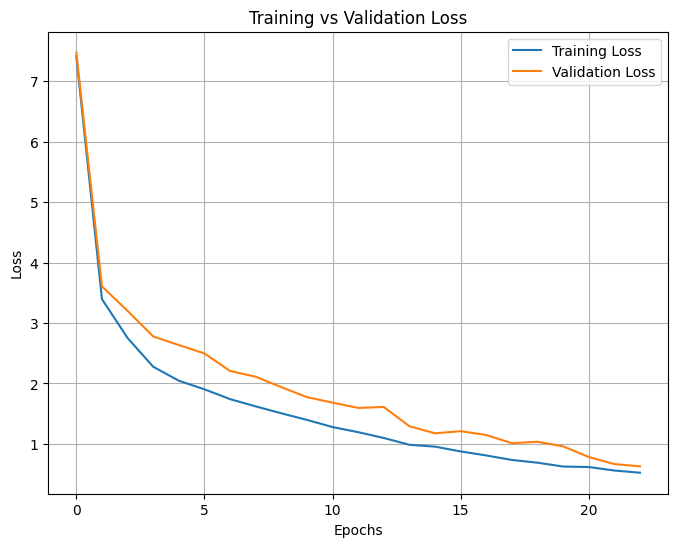

In [32]:
import matplotlib.pyplot as plt



# Plot
plt.figure(figsize=(8, 6))
plt.plot(tr_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [29]:

def generate_text(model, tokenizer, prompt, max_length=100, top_k=50, temperature=1.0, device='cuda'):

    model.eval()
    input_ids = torch.tensor(tokenizer.encode(prompt).ids, device=device).unsqueeze(0)  # Shape: [1, seq_len]

    generated = input_ids.tolist()[0]  # Keep track of generated token ids

    with torch.no_grad():
        for _ in range(max_length):
            outputs = model(input_ids)
            logits = outputs[:, -1, :]  # Take the last token's logits

            # Apply temperature
            logits = logits / temperature

            # Top-k sampling
            top_k_logits, top_k_indices = torch.topk(logits, top_k)
            probs = F.softmax(top_k_logits, dim=-1)

            # Sample from the distribution
            next_token = top_k_indices[0, torch.multinomial(probs[0], 1)].item()

            generated.append(next_token)

            # Append next token to input_ids
            input_ids = torch.tensor([generated], device=device)

    # Decode token ids to string
    text = tokenizer.decode(generated)
    return text




In [33]:
# Example Bengali prompt
bengali_prompt = "অপরাজিত মানুষ সব বাধা অতিক্রম করে স্বপ্ন পূরণের পথে এগিয়ে যায়"

# Generate text using the trained model
generated_text = generate_text(
    model=model,
    tokenizer=bpe_tokenizer,
    prompt=bengali_prompt,
    max_length=100,   # number of tokens to generate
    top_k=25,         # top-k sampling
    temperature=0.1,  # temperature scaling
    device='cuda'
)

print("Generated Bengali Text:\n", generated_text)


Generated Bengali Text:
  অপরাজিত মানুষ সব বাধা অতিক্রম করে স্বপ্ন পূরণের পথে এগিয়ে যায়নি, মানবিক নয়! তুমি এই মুহূর্তে কী আছে? নৈঋতের প্রশ্নের উত্তর পাওয়া যাবে এটাই সে কিনা যে ক্ষমতা দিতে পারে নি? - বলেন হরিশ বাবু স্কুলের পা


In [25]:
#generate text using KV caching

# generate text using KV caching
def generate_text(model, tokenizer, prompt, max_length=100, top_k=50, temperature=1.0, device='cuda'):
    model.eval()

    # Encode prompt
    input_ids = torch.tensor([tokenizer.encode(prompt).ids], device=device)  # [1, seq_len]
    generated = input_ids.tolist()[0]

    past_kv = None  # Initialize cache
    position_offset = 0  # absolute token position for RoPE

    with torch.no_grad():
        for _ in range(max_length):
            # --- first step: feed full prompt ---
            if past_kv is None:
                logits, past_kv = model(
                    input_ids,
                    return_cache=True,
                    seq_start=position_offset   # start from 0
                )
                position_offset += input_ids.size(1)

            # --- subsequent steps: feed last token only ---
            else:
                last_token = input_ids[:, -1:]  # shape [1,1]
                logits, past_kv = model(
                    last_token,
                    return_cache=True,
                    past_kv=past_kv,
                    seq_start=position_offset  # absolute position
                )
                position_offset += 1

            # --- take logits of last token ---
            next_token_logits = logits[:, -1, :] / temperature

            # --- top-k sampling ---
            top_k_logits, top_k_indices = torch.topk(next_token_logits, k=top_k, dim=-1)
            probs = F.softmax(top_k_logits, dim=-1)
            next_token = top_k_indices[0, torch.multinomial(probs[0], 1)].item()

            # --- append to generated sequence ---
            generated.append(next_token)
            input_ids = torch.tensor([[next_token]], device=device)  # feed only last token next

    # Decode generated token ids
    text = tokenizer.decode(generated, skip_special_tokens=True)
    return text



In [26]:
# Example Bengali prompt
bengali_prompt = "আজকে সকালে"

# Generate text using the trained model
generated_text = generate_text(
    model=model,
    tokenizer=bpe_tokenizer,
    prompt=bengali_prompt,
    max_length=100,   # number of tokens to generate
    top_k=25,         # top-k sampling
    temperature=0.1,  # temperature scaling
    device='cuda'
)

print("Generated Bengali Text:\n", generated_text)


Generated Bengali Text:
  আজকে সকালের এক পরের একটারন্ষম্র ভাত) দিয়ার সবায়া অবস্দ্দ্দ্দ্দ্দ্দ্দ্দ্দ্দ্দ্দ্দ্দ্দ্দ্দ্দ্দ্দ্দ্দ্দ্দ্দ্দ্দ্দ্দ্দ্দ্দ্দ্দ্দ্


In [31]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import bert_score

prompts = [
    "আজকে সকালে",
    "বাংলাদেশের রাজধানী হলো",
    "আমার প্রিয় খেলা হলো",
    "আমি আজ স্কুলে গেলাম",
    "পাঠশালায় অনেক বন্ধু আছে"
]

references = [
    ["আজকে সকালে আমি চায়ের কাপ নিয়ে বসেছিলাম।"],
    ["বাংলাদেশের রাজধানী হলো ঢাকা।"],
    ["আমার প্রিয় খেলা হলো ক্রিকেট।"],
    ["আমি আজ স্কুলে সকালেই পৌঁছলাম।"],
    ["পাঠশালায় অনেক বন্ধু আছে যারা আমার সাথে খেলতে ভালোবাসে।"]
]

# -------------------------------
# 4. BLEU evaluation
# -------------------------------
print("===== BLEU Scores =====")
smooth_fn = SmoothingFunction().method1
bleu_scores = []

for i, prompt in enumerate(prompts):
    generated = generate_text(model, bpe_tokenizer, prompt)
    reference = [references[i][0].split()]
    candidate = generated.split()
    score = sentence_bleu(reference, candidate, smoothing_function=smooth_fn)
    bleu_scores.append(score)
    print(f"Prompt: {prompt}")
    print(f"Generated: {generated}")
    print(f"BLEU: {score:.4f}\n")

avg_bleu = sum(bleu_scores)/len(bleu_scores)
print(f"Average BLEU Score: {avg_bleu:.4f}\n")

# -------------------------------
# 5. ROUGE evaluation
# -------------------------------
print("===== ROUGE Scores =====")
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
for i, prompt in enumerate(prompts):
    generated = generate_text(model, bpe_tokenizer, prompt)
    scores = scorer.score(references[i][0], generated)
    print(f"Prompt: {prompt}")
    print(f"Generated: {generated}")
    print(f"ROUGE: {scores}\n")

# -------------------------------
# 6. BERTScore evaluation
# -------------------------------
print("===== BERTScore =====")
all_generated = [generate_text(model, bpe_tokenizer, p) for p in prompts]
all_references = [r[0] for r in references]

P, R, F1 = bert_score.score(all_generated, all_references, lang="bn")
for i, prompt in enumerate(prompts):
    print(f"Prompt: {prompt}")
    print(f"Generated: {all_generated[i]}")
    print(f"BERTScore F1: {F1[i].item():.4f}\n")

print(f"Average BERTScore F1: {F1.mean().item():.4f}")

===== BLEU Scores =====
Prompt: আজকে সকালে
Generated:  আজকে সকালে ঘৃণায় নদীর পাড়ে ফেলে তাকাতে জানালার চর মুশকিল কালো ধোঁয়ার মত কামরা দ্বিরেফের তার সব সময় সম্মানের চোখে মুখের মতই লানতারজে পরিচারিকার সু
BLEU: 0.0160

Prompt: বাংলাদেশের রাজধানী হলো
Generated:  বাংলাদেশের রাজধানী হলো জাতীয় সংসদ নেতিবাচকভাবে ক্ষেস করার হয়েছেন, জীবিতায় নির্বাচনে সরকারি বা সেক্ষেত্রে অগ্রসর বাংলাদেশে শীর্ষিক; এর অর্থনৈতিক দল খেলা পরাবর
BLEU: 0.0430

Prompt: আমার প্রিয় খেলা হলো
Generated:  আমার প্রিয় খেলা হলো কথা শেষ করেই ফিরতে হয় কেউ ছিঁড়ে ফেলে দ্বিরেফকে প্রতিযোগিতা করার সময় নয় সেই সামলানো হয়েছে লাশ কেউ অভিজাত পাওয়ার পরও হোসায়েন, কুরো চোরাচালা
BLEU: 0.0836

Prompt: আমি আজ স্কুলে গেলাম
Generated:  আমি আজ স্কুলে গেলাম কীর্যকর এলো কোথাও বেলাল-প্রতাহিত্ আসবেই আর কিন্তু বিতর্কের উপরাটাই চূড়ান্ত প্রবেশাধিকার নেইস্তাশক্তি কী আর কয়েক ঘটনা কাটছা হয় নৈঋতের তাক্
BLEU: 0.0392

Prompt: পাঠশালায় অনেক বন্ধু আছে
Generated:  পাঠশালায় অনেক বন্ধু আছে না, অনেকে নেই নিয়ম এই নির্বাচনে এই রিপালটা মন্ত্রীয় দিন

In [27]:
!pip install bert_score
!pip install rouge_score
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=cbd62264a4e0156ad33e2c1c9b1ddf124bf95ead06025752ade7485bdad937ff
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score
